# Investigation - Price delta

I have fairly successfully replicated and extended the notebook with the first investigation notebook. In this one, I want to add the ability to predict a candle close further forward in time. ie. x + n candles instead of just x + 1.

I also wanted to change from predicting the price to predicting the price change. There are times when the price goes outside what the model has seen before. When this happens, the model hits a limit of what it can predict the price to be. However, by predicting the change in price you are able to predict any price. However, you do still have the limit applied when the price change goes outside what is seen before. But this likely occurs less often and would not be sustained for long periods of time

## Analysis

This method removes the limitation of having to stay inside price ranges seen in training. But the predictions "lag" a bit so in reality we more end up following the price trend rather than predicting it.

### Note

In this repo I am using a custom module `malfoy.metatrader` that I built on top of the `MetaTrader5` package. This interfaces directly with MetaTrader to pull up-to-date data. I hope to eventually make this open-source but for now it's a private module. I have also saved the data used in `./data/new` so it can be reused.



In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

%matplotlib widget

C:\Python310\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: 0.-minor-version- is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# Functions

def CreateScaler(data: pd.Series) -> MinMaxScaler:
  data = np.array(data).reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)

  return scaler

def GetScaledData(data: pd.Series, scaler: MinMaxScaler) -> pd.Series:
  data = np.array(data).reshape(-1, 1)
  return scaler.transform(data)

def GetTimeStepDataFrame(data: pd.DataFrame, lookbackTimeSteps: int, trainingColumns: list) -> pd.DataFrame:
  timeStepData = pd.DataFrame(index=data.index)

  for column in trainingColumns:
    for i in range(0, lookbackTimeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].shift(i)

  timeStepData["target"] = data["target"]
  
  timeStepData = timeStepData.dropna()

  return timeStepData

## Variables

These core variables are used throughout the scripts. The instrument and granularity variables can be used to change the target of predictions. These correspond to the data found in `./data/new/`

*Prediction Variables*:
- instrument - the instrument being predicted
- granularity - the timeframe being predicted on (One minute, one hour, one day, etc)
- lookbackTimeSteps - the number of previous time steps to use in making the prediction for the current candle
- predictionTimeSteps - the number of candles forward to predict. ie. predict the candle x + n from now.
- predictionColumn - the column from the dataframe we are trying to predict

In [3]:
# Set script variables
seedValue = 72
trainingSizePercent = 0.7
inputDataFolder = "./input"

# Change these for prediction changes
instrument = "AUDUSD"
granularity = "H1"
lookbackTimeSteps = 3
predictionTimeSteps = 2
predictionColumn = "targetDelta"

In [5]:
# Import data

rawDataFilePath = "{0}/{1}_{2}.csv".format(inputDataFolder, instrument, granularity)
rawData = pd.read_csv(rawDataFilePath)

rawData

,Unnamed: 0,instrument,granularity,time,stringTime,volume,bidOpen,bidHigh,bidLow,bidClose,...,bbandsm_10,bbandsu_10,bull_signal_bbands_10,bear_signal_bbands_10,bbandsl_15,bbandsm_15,bbandsu_15,bull_signal_bbands_15,bear_signal_bbands_15,cmf
0,0,AUDUSD,H1,2021-07-08 04:00:00,2021-07-08T04:00:00,3951,0.74681,0.74693,0.74555,0.74557,...,NaN,NaN,False,False,NaN,NaN,NaN,False,False,NaN
1,1,AUDUSD,H1,2021-07-08 05:00:00,2021-07-08T05:00:00,3626,0.74557,0.74637,0.74542,0.74634,...,NaN,NaN,False,False,NaN,NaN,NaN,False,False,NaN
2,2,AUDUSD,H1,2021-07-08 06:00:00,2021-07-08T06:00:00,2108,0.74634,0.74662,0.74585,0.74634,...,NaN,NaN,False,False,NaN,NaN,NaN,False,False,NaN
3,3,AUDUSD,H1,2021-07-08 07:00:00,2021-07-08T07:00:00,1677,0.74634,0.74677,0.74620,0.74644,...,NaN,NaN,False,False,NaN,NaN,NaN,False,False,NaN
4,4,AUDUSD,H1,2021-07-08 08:00:00,2021-07-08T08:00:00,2987,0.74644,0.74644,0.74539,0.74608,...,NaN,NaN,False,False,NaN,NaN,NaN,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,AUDUSD,H1,2022-04-26 09:00:00,2022-04-26T09:00:00,4142,0.72177,0.72201,0.71954,0.71958,...,0.719769,0.723283,False,True,0.714788,0.718813,0.722837,False,False,-0.020042
4996,4996,AUDUSD,H1,2022-04-26 10:00:00,2022-04-26T10:00:00,5189,0.71957,0.71988,0.71783,0.71836,...,0.719788,0.723265,False,False,0.715136,0.718944,0.722752,False,True,-0.126218
4997,4997,AUDUSD,H1,2022-04-26 11:00:00,2022-04-26T11:00:00,3723,0.71836,0.72027,0.71836,0.72007,...,0.719974,0.723270,True,False,0.715608,0.719187,0.722765,True,False,-0.046370
4998,4998,AUDUSD,H1,2022-04-26 12:00:00,2022-04-26T12:00:00,2697,0.72007,0.72154,0.71979,0.72114,...,0.720325,0.723237,False,False,0.716094,0.719491,0.722889,False,False,0.039084


In [6]:
# Pre-process data

ppData = rawData.copy()

# New columns
ppData["previousCloseDelta"] = ppData["midClose"] - ppData["midClose"].shift(1)
ppData["openCloseDelta"] = ppData["midClose"] - ppData["midOpen"]
ppData["targetDelta"] = ppData["midClose"].shift(-predictionTimeSteps) - ppData["midClose"]

# Shift the target column so that the future target is at the time point we want to predict from.
# ie. If we want to predict the closing price in 2 candles time, we move the closing price, back two rows
ppData["target"] = ppData[predictionColumn].shift(-predictionTimeSteps)
ppData = ppData.dropna()

# Drop columns that wont be used in processing/prediction
dropColumns = ["Unnamed: 0", "instrument", "granularity", "time", "stringTime", "volume", "bidOpen", "bidHigh", "bidLow", "bidClose", "midOpen", "midHigh", "midLow", "midClose", "askOpen", "askHigh", "askLow", "askClose", "targetDelta"]
ppData = ppData.drop(columns=dropColumns)

# Select the columns based on the float data type. These will then be scaled.
# For now, we are also using them all to train the model
scaledColumns = ppData.select_dtypes(include='float64').columns
trainingColumns = scaledColumns.drop("target")

# Split data in to test and train
trainingEntryCount = math.floor(len(ppData) * trainingSizePercent)
trainingData = ppData.iloc[0:trainingEntryCount, :]
testData = ppData.iloc[trainingEntryCount:len(ppData), :]

# Scale required columns
scalerDict = {}

for column in scaledColumns:
  scalerDict[column] = CreateScaler(trainingData[column])
  
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
  testData[column] = GetScaledData(testData[column], scalerDict[column])

# Add previous time steps as data available for making prediction
trainingTimeStepData = GetTimeStepDataFrame(trainingData, lookbackTimeSteps=lookbackTimeSteps, trainingColumns=trainingColumns)
X_trainingData = trainingTimeStepData.drop(columns=["target"])
Y_trainingData = trainingTimeStepData["target"]

testTimeStepData = GetTimeStepDataFrame(testData, lookbackTimeSteps=lookbackTimeSteps, trainingColumns=trainingColumns)
X_testData = testTimeStepData.drop(columns=["target"])
Y_testData = testTimeStepData["target"]

print("X_trainingData shape:", X_trainingData.shape)
print("Y_trainingData shape:", Y_trainingData.shape)
print("X_testData shape:", X_testData.shape)
print("Y_testData shape:", Y_testData.shape)

C:\Users\sambe\AppData\Local\Temp\ipykernel_15568\2008775571.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_15568\2008775571.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData[column] = GetScaledData(testData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_15568\2008775571.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

X_trainingData shape: (3456, 1180)
Y_trainingData shape: (3456,)
X_testData shape: (1480, 1180)
Y_testData shape: (1480,)


C:\Users\sambe\AppData\Local\Temp\ipykernel_15568\2770001933.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeStepData[newColName] = data[column].shift(i)
C:\Users\sambe\AppData\Local\Temp\ipykernel_15568\2770001933.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeStepData["target"] = data["target"]


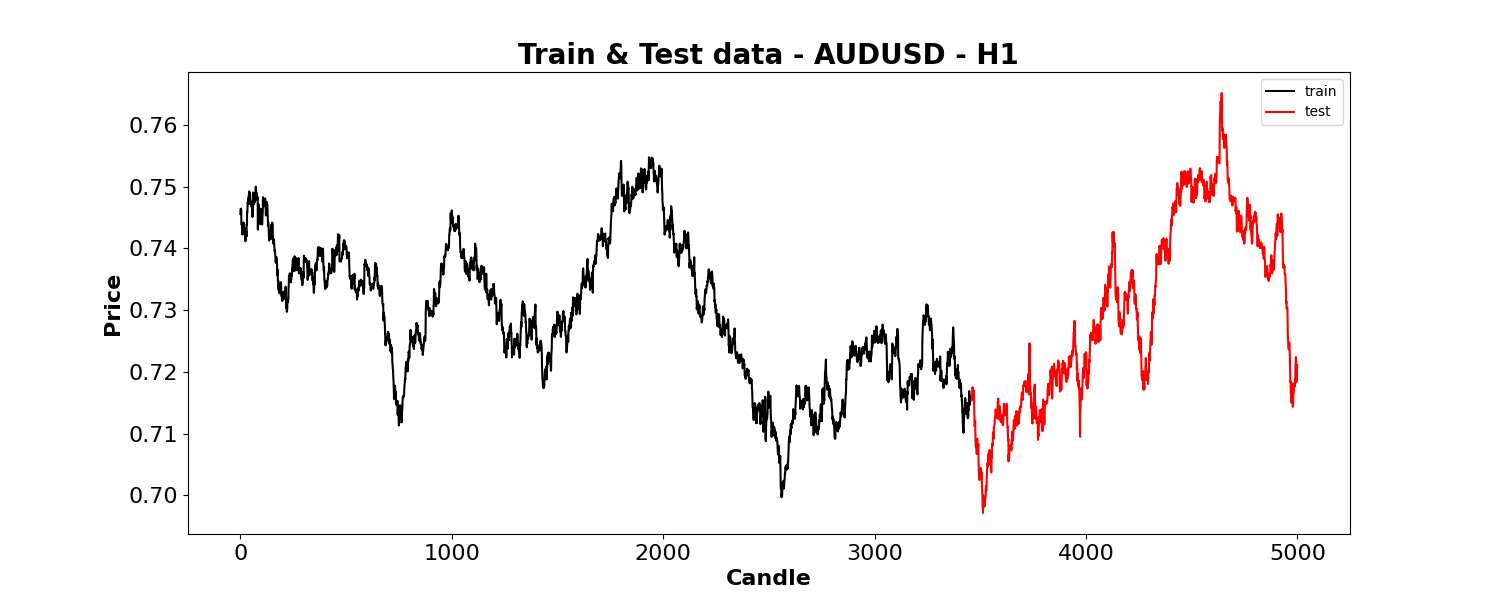

In [7]:
# Plot test and train data

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')

# Formatting
ax.set_title('Train & Test data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [8]:
# Train model

# model = XGBRegressor(n_estimators=1000, seed=seedValue)
# model.fit(X_trainingData, Y_trainingData, verbose=False)

dataShape = X_trainingData.shape[1]

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=([dataShape, 1])))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(X_trainingData,Y_trainingData,validation_data=(X_testData,Y_testData),epochs=10,batch_size=32,verbose=1)

Epoch 1/10
108/108 [==============================] - 475s 4s/step - loss: 0.0326 - val_loss: 0.0132
Epoch 2/10
108/108 [==============================] - 164s 1s/step - loss: 0.0114 - val_loss: 0.0135
Epoch 3/10
108/108 [==============================] - 106s 979ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 4/10
108/108 [==============================] - 108s 1s/step - loss: 0.0110 - val_loss: 0.0135
Epoch 5/10
108/108 [==============================] - 106s 985ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 6/10
108/108 [==============================] - 105s 973ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 7/10
108/108 [==============================] - 107s 987ms/step - loss: 0.0107 - val_loss: 0.0132
Epoch 8/10
108/108 [==============================] - 107s 991ms/step - loss: 0.0104 - val_loss: 0.0131
Epoch 9/10
108/108 [==============================] - 108s 1s/step - loss: 0.0102 - val_loss: 0.0138
Epoch 10/10
108/108 [==============================] - 108s 1s/step - loss: 

In [9]:
# Model testing and evaluation

predictions = model.predict(X_testData)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_testData, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_testData, predictions))))
print("Test data explained variance regression score:", explained_variance_score(Y_testData, predictions))

Mean Absolute Error - MAE : 0.085818986310271
Root Mean squared Error - RMSE : 0.11511064062325531
Test data explained variance regression score: 0.0009544591794485857


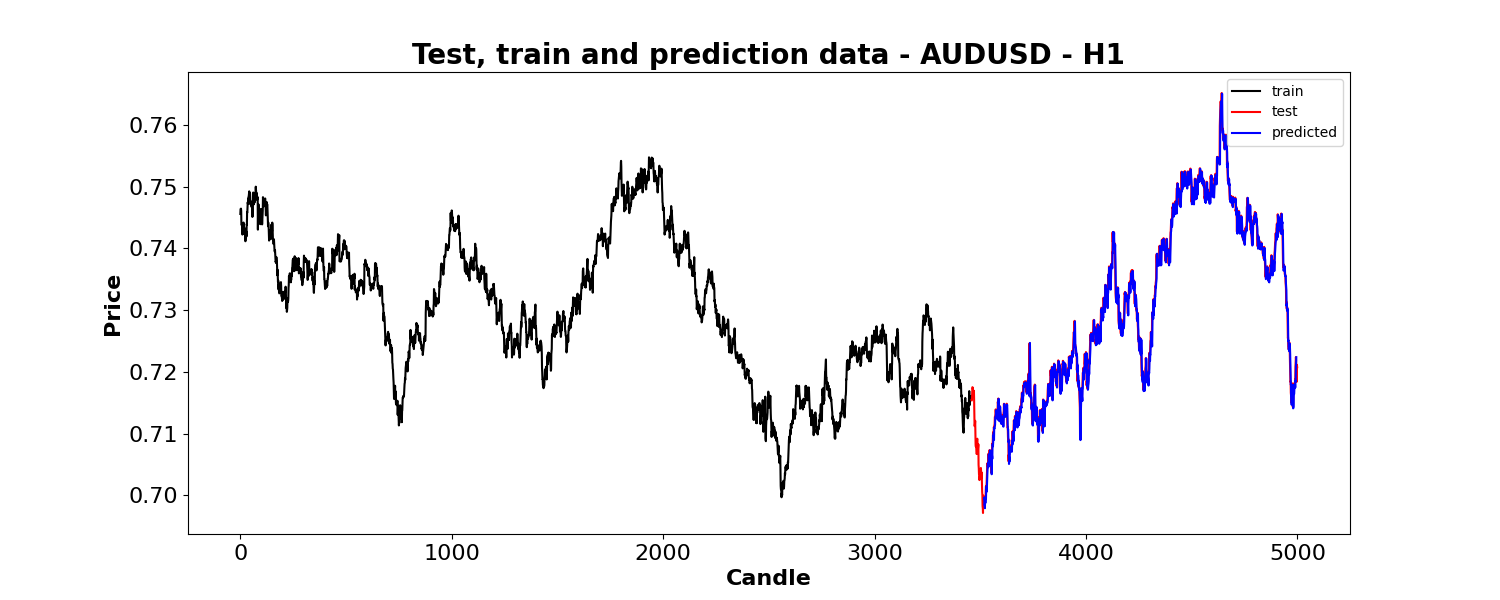

In [11]:
# Plot the predicted vs actual
plotTestData = X_testData.copy()

plotTestData["midClose"] = rawData.dropna().iloc[trainingEntryCount:len(ppData), :]["midClose"]

plotTestData["PredictedValue"] = scalerDict["target"].inverse_transform(np.array(predictions).reshape(-1, 1))
plotTestData["PredictedCloseDelta"] = plotTestData["PredictedValue"]
plotTestData["PredictedValue"] = plotTestData["PredictedValue"] + plotTestData["midClose"]
plotTestData["PredictedValue"] = plotTestData["PredictedValue"].shift(predictionTimeSteps)

plotTestData = plotTestData.dropna(axis=0)

plotTestData.to_csv("./predictions.csv")

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedValue'], color = 'blue')

# Formatting
ax.set_title('Test, train and prediction data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test', "predicted"))


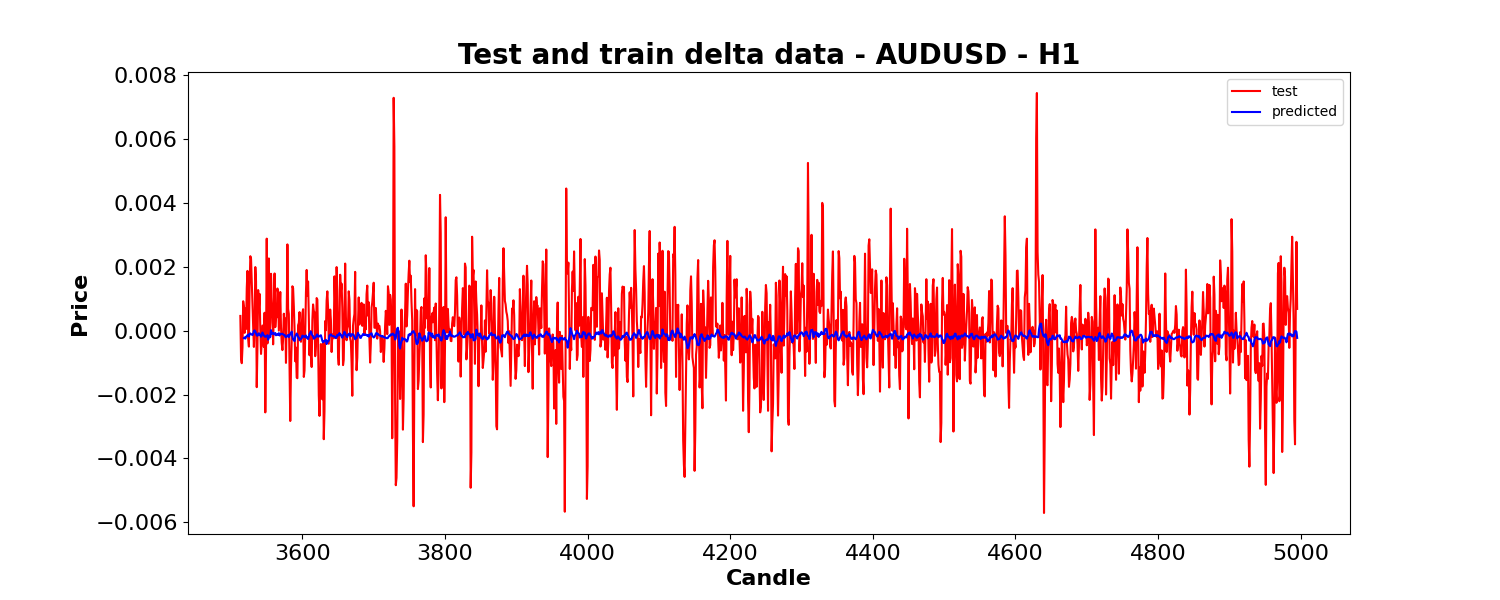

In [12]:
# Plot delta changes

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x = ppData.index[trainingEntryCount:], y = ppData["target"][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedCloseDelta'], color = 'blue')

# Formatting
ax.set_title('Test and train delta data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('test', "predicted"))